In [1]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net, SCVIZ_CheckNet2Net
import pickle5
from tqdm import tqdm 
from sklearn.neighbors import NearestNeighbors
from perturbnet.baselines.knn import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load Data and PerturbNet

In [2]:
some_path = ""
path_cinn_model = some_path + '/cinn/50ep/'

path_data = ""
path_scvi_model_train = some_path +  '/cellvae/700ep/model/' 
#path_scvi_model_eval = '/nfs/turbo/umms-welchjd/wzqian/model_save/jorge/gata1/holdout1/cellvae/700ep/model/' 
    
adata = ad.read_h5ad(os.path.join(path_data, "GATA1_standard_hvg_pert_filtered.h5ad"))

adata_save_index = np.array(adata.obs[adata.obs["UTR_cond"] != "UTR Mutated"].index).astype(int)    
adata = adata[adata_save_index, :].copy()
adata.obs = adata.obs.reset_index(drop = True)
print(adata.obs.shape)

    
with open(some_path + "gata1_rank_genes_groups_UTR_removed.pkl", "rb") as fh:
    degs = pickle5.load(fh)
adata.uns["rank_genes_groups"] = degs

#scvi.data.setup_anndata(adata, layer = "counts")
adata_test_index = np.array(adata.obs[adata.obs["holdout1"] == "test"].index).astype(int)
adata_test = adata[adata_test_index, :].copy()
    
adata_train_index = np.array(adata.obs[adata.obs["holdout1"] == "train"].index).astype(int)
adata_train = adata[adata_train_index, :].copy()

scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model_cinn = scvi.model.SCVI.load(path_scvi_model_train, adata_train, use_cuda = False)
    
perturb_with_onehot_kept, perturb_with_onehot_removed = np.array(adata_train.obs["variant_seq"]), np.array(adata_test.obs["variant_seq"])
trt_obs_list, trt_unseen_list = np.unique(perturb_with_onehot_kept), np.unique(perturb_with_onehot_removed)    

onehot_unseen_idx = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_trt"] == trt)[0][0]
    
    onehot_unseen_idx.append(onehot_idx)
    unseen_onehot = adata.uns["ordered_all_embedding"][onehot_unseen_idx]

onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_trt"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
    seen_onehot = adata.uns["ordered_all_embedding"][onehot_seen_idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

perturbToEmbed = {}
for i in range(trt_obs_list.shape[0]):
    perturbToEmbed[trt_obs_list[i]] = i
        
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim=1280,embedding_dim=10,conditioning_depth=2,n_flows=20,in_channels=10,hidden_dim=1024,
hidden_depth=2,activation="none",conditioner_use_bn=True)

model_c = Net2NetFlow_scVIFixFlow(configured_flow = flow_model,
                                 cond_stage_data = perturb_with_onehot_kept,
                                perturbToEmbedLib = perturbToEmbed,
                                  embedData = seen_onehot,
                                     scvi_model = scvi_model_cinn)
model_c.to(device = device)
model_c.load(path_cinn_model)
model_c.eval()
scvi_model_de = scvi_predictive_z(scvi_model_cinn)
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)
if sparse.issparse(adata_test.X):
    usedata = adata_test.X.A
else:
    usedata = adata_test.X

if sparse.issparse(adata_test.layers["counts"]):
    usedata_count = adata_test.layers["counts"].A
else:
    usedata_count = adata_test.layers["counts"]

fidscore_cal = fidscore()

normModel = NormalizedRevisionRSquare(largeCountData = usedata_count)
Lsample_obs = scvi_model_cinn.get_latent_library_size(adata = adata_train, give_mean = False)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

(142872, 18)


/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 122219 cells, 2477 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                         

In [3]:
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
fid_mu = []
fid_sample = []
pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
for indice_trt in range(len(trt_unseen_list)):
    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type  =  np.random.choice(idx_trt_type, 1000, replace = False)
    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), 500, replace=True)
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (500, 1))



    trt_onehot = onehot_indice_trt + np.random.normal(scale = 0.001, size = onehot_indice_trt.shape)
    library_trt_latent =Lsample_obs[Lsample_idx]

    _, fake_data = perturbnet_model.sample_data(trt_onehot, library_trt_latent)
    real_data = usedata_count[idx_trt_type]
    r2_value, real_norm, rfake_norm = normModel.calculate_r_square(real_data, fake_data)
    pear_value = normModel.calculate_pearson(real_data, fake_data)

        

    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = normModel.calculate_pearson(real_data_deg, fake_data_deg)

   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value,_ ,_  = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

results_PerturbNet = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })

# Training Sample

In [6]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
fid_mu = []
fid_sample = []
pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    seen_data = adata_train.layers["counts"].A
    seen_data_idx = list(range(seen_data.shape[0]))

    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    norm_vec_real = adata[real_data_idx, :].obs["n_counts_total"].to_numpy()
    idx_rsample = np.random.choice(seen_data_idx, len(real_data_idx), replace=True)
    fake_data = seen_data[idx_rsample]
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_rsample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value= normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)

    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

    
results_sample = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


 87%|████████▋ | 45/52 [00:42<00:07,  1.00s/it]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


100%|██████████| 52/52 [00:48<00:00,  1.07it/s]


# KNN

In [7]:
neigh = NearestNeighbors(n_neighbors=5)
neigh_fit = neigh.fit(seen_onehot)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
seen_data_idx = list(range(seen_data.shape[0]))

for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]

    #fake_data = pred
    real_data_idx = adata.obs[adata.obs["variant_seq"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    norm_vec_real = adata[real_data_idx, :].obs["n_counts_total"].to_numpy()
    distances, other_trts = neigh_fit.kneighbors(unseen_onehot[[indice_trt]], 5, return_distance=True)
    samplerNN = samplefromNeighbors(distances, other_trts)
    idx_sample = samplerNN.samplingTrt(trt_obs_list, perturb_with_onehot_kept, len(real_data_idx))
    
    fake_data = seen_data[idx_sample]
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_sample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)


    
    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value= normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

    
results_KNN = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


 87%|████████▋ | 45/52 [00:08<00:01,  4.12it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


100%|██████████| 52/52 [00:09<00:00,  5.52it/s]


../perturbnet/util.py:963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


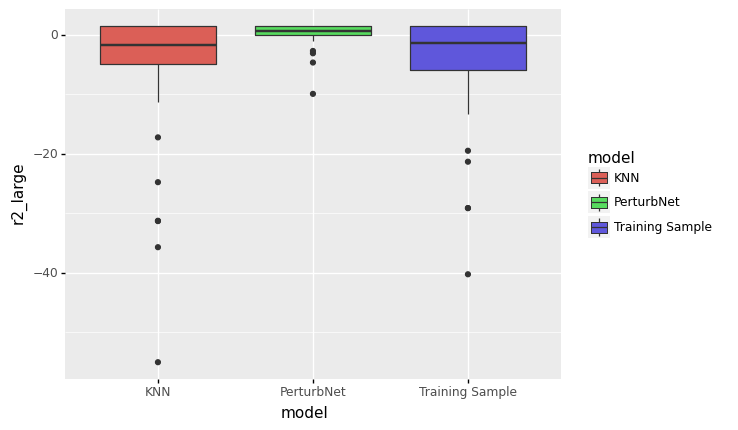

<ggplot: (1425739028341)>

In [9]:
boxplot_metrics({"PerturbNet":results_PerturbNet, "Training Sample":results_sample,
                "KNN": results_KNN }, metric_key = "r2_large")